In [39]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageOps
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
from torchvision import models
import matplotlib.pyplot as plt
import os
import sys
import random

import utils

Подготовка датасета

In [2]:
TRAIN_DATA_DIR = 'data/train_images/train_images'
TEST_DATA_DIR = 'data/test_images/test_images'

In [3]:
with open('data/usdc_train.json', 'r') as file:
    train_data = json.load(file)

In [4]:
classes_dict = {}
for sample in train_data['categories']:
    classes_dict[sample['id']-1] = sample['name']
del classes_dict[-1]
classes_dict 

{0: 'biker',
 1: 'car',
 2: 'pedestrian',
 3: 'trafficLight',
 4: 'trafficLight-Green',
 5: 'trafficLight-GreenLeft',
 6: 'trafficLight-Red',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-Yellow',
 9: 'trafficLight-YellowLeft',
 10: 'truck'}

In [5]:
classes_colors = ['red', 'blue', 'green', 'violet', 'gold', 'brown',
                  'darkseagreen', 'aquamarine', 'olive', 'plum', 'sandybrown']

In [6]:
annotations_df = pd.DataFrame(train_data['annotations'])
annotations_df = annotations_df.drop(columns=['id', 'segmentation', 'iscrowd', 'confidence', 'score'])
annotations_df.head()

,image_id,category_id,bbox,area
0,5,2,"[196, 234, 20.266666666666666, 24.74666666666667]",501.532444
1,5,2,"[247, 236, 16.53333333333333, 24.74666666666667]",409.144889
2,5,2,"[265, 234, 20.8, 23.893333333333334]",496.981333
3,5,2,"[267, 237, 15.466666666666667, 17.066666666666...",263.964444
4,5,2,"[305, 233, 78.93333333333334, 75.94666666666667]",5994.723556


In [7]:
annotations_df['category_id'].unique()

array([ 2,  8,  1,  7, 11,  3,  4,  5,  9,  6, 10])

In [8]:
annotations_df['category_id'] = annotations_df['category_id'].apply(lambda x: x - 1)

In [9]:
images_df = pd.DataFrame(train_data['images'])
images_df = images_df.drop(columns=['license', 'height', 'width', 'date_captured'])
images_df = images_df.rename(columns={'id' : 'image_id'})
images_df.head()

,image_id,file_name
0,5,1478020898717725646_jpg.rf.68EjFVQdDWrB0SW6qVl...
1,14,1478020650710690845_jpg.rf.68NUjFyrbU9Nsyt3ika...
2,22,1478898975867837103_jpg.rf.6847BekYxQ4SlhtvjlE...
3,57,1478895940606118436_jpg.rf.68xNq7HL27EKmRnrGgp...
4,58,1478896447910420804_jpg.rf.68xeyVz6sbVFpLVku7W...


In [10]:
train_annotations = utils.create_dataset(images_df, annotations_df)

In [11]:
file_names = [file_name["file_name"] for file_name in train_annotations]

In [12]:
class DetectionDataset(Dataset):
    def __init__(self, annotations: dict, img_dir: str, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        sample = self.annotations[idx]
        img_path = os.path.join(TRAIN_DATA_DIR, sample['file_name'])
        
        image = Image.open(img_path)
        
        bboxes = []
        labels = []
        for obj in sample['annotations']:
            bboxes.append(obj['bbox'])
            labels.append(obj['class'])
            
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        w_old, h_old = image.size
        
        if self.transform: 
            image, bboxes = self.transform.forward(image, bboxes)
            
        return image, {'bboxes' : bboxes, 'labels' : labels}

In [13]:
train_dataset = DetectionDataset(train_annotations, TRAIN_DATA_DIR)

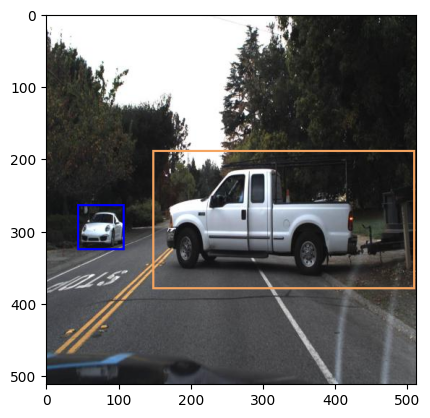

In [14]:
image = train_dataset[2323][0]
bboxes = train_dataset[2323][1]['bboxes']
labels = train_dataset[2323][1]['labels']

utils.plot_image(image, bboxes, labels, classes_colors)

Добавление Local Contrast Normalization и различных трансформаций

In [15]:

class BasicTransform:
    def __init__(self, resize=None, lcn=False):
        self.resize = resize
        self.lcn = lcn
        
    def forward(self, img, bboxes):
        resize = self.resize
        lcn = self.lcn
        
        if random.uniform(0, 1) < 0.5:
            img = ImageOps.mirror(img)
            for i, bbox in enumerate(bboxes):
                x, y, w, h = bbox.tolist()
                new_x = img.size[0] - x - w
                bboxes[i] = torch.tensor([new_x, y, w, h])
                
        
        angle = random.randint(-30, 30)
        r_image = img.rotate(angle, expand=1)
        for i, bbox in enumerate(bboxes):
            bboxes[i] = torch.tensor(utils.rotate_bbox(bbox, img.size, r_image.size, angle),
                                    dtype=torch.float32)
        
        r_image = v2.ColorJitter(brightness=(0.4, 2), contrast=(1, 6),
                saturation=(0, 2.5), hue=(-0.25,0.25))(r_image)
        
        r_image = v2.RandomInvert(0.3)(r_image)
        
        if resize:
            r_image = transforms.Resize(resize)(r_image)
            w_new, h_new = r_image.size
            w_old, h_old = r_image.size
            scale_x = w_new / w_old
            scale_y = h_new / h_old
            for i, bbox in enumerate(bboxes):
                x_old, y_old, w_old, h_old = bbox
                bboxes[i] = torch.tensor([x_old * scale_x, y_old * scale_y, w_old * scale_x, h_old * scale_y],
                                            dtype=torch.float32)
        
        r_image = transforms.ToTensor()(r_image)
        
        if lcn:
            r_image = utils.LocalContrastNorm(kernel_size=7)(r_image)
        
        return r_image, bboxes

In [16]:
train_dataset_tr = DetectionDataset(train_annotations, TRAIN_DATA_DIR, transform=BasicTransform(lcn=False, resize=(512, 512)))

In [71]:
train_dataset_tr[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 {'bboxes': tensor([[373.4101, 300.9474,  29.9248,  31.5646],
          [333.4760, 328.1795,  26.6916,  29.6979],
          [313.1924, 335.4474,  29.9600,  31.0922],
          [317.5792, 339

In [1]:
img, dct = train_dataset_tr[5555]
img = transforms.functional.to_pil_image(img)
bboxes = dct['bboxes']
labels = dct['labels']
utils.plot_image(img, bboxes, labels, classes_colors)

NameError: name 'train_dataset_tr' is not defined

In [ ]:
box = torch.tensor([1, 7, 3 , 4])
a = torch.tensor([[0, 1, 5, 6], 
                  [6, 7, 8, 9]])
torch.where(a[: 0] > box[0], 1, 0)
a[:]

tensor([], size=(0, 4), dtype=torch.int64)

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        return x

class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DetectionHead, self).__init__()
        self.fc = nn.Linear(in_channels, 256)
        self.soft_max = nn.Softmax(dim=1)
        self.cls_layer = nn.Linear(4, num_classes)
        self.reg_layer = nn.Linear(256, 4 * 100)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        reg_out = self.reg_layer(x)
        reg_out = reg_out.resize(reg_out.size()[0], 4)
        cls_out = self.soft_max(self.cls_layer(reg_out))
        return cls_out, reg_out
    
class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(ObjectDetectionModel, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.detection_head = DetectionHead(in_channels=32 * 128 * 128, num_classes=num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        cls_out, reg_out = self.detection_head(features)
        return cls_out, reg_out

In [73]:
train_dataloader = DataLoader(train_dataset_tr, batch_size=64, shuffle=True)

In [ ]:
model = ObjectDetectionModel(num_classes=12)
for i in train_dataloader:
    print(i[1])
    model(i[0])
    break

[{'bboxes': tensor([[133.3640, 396.6639,  60.4433,  61.2410],
        [206.3248, 377.7954,  38.8920,  39.3828],
        [229.8811, 371.5800,  21.0534,  21.6670],
        [245.1768, 366.7797,  20.7476,  20.8703],
        [288.9136, 347.3507,  20.4771,  23.4836],
        [448.2065, 270.4433,  35.0069,  56.9109],
        [455.7414, 274.7822,  38.7980,  59.0455]]), 'labels': tensor([1, 1, 1, 1, 1, 2, 2])}, {'bboxes': tensor([[441.2602, 295.8203,  36.5429,  22.8856],
        [444.0604, 296.0203,  30.7500,  23.3276],
        [390.7305, 290.2862,  32.3461,  23.4392],
        [392.2042, 291.4000,  29.8050,  24.9557],
        [352.1808, 282.6616,  30.3444,  40.2410],
        [351.2913, 221.3172,   5.5621,  11.4011],
        [323.1086, 281.5479,  17.4492,  22.3975],
        [284.1714, 246.7053,   6.7452,  13.1780]]), 'labels': tensor([1, 1, 1, 1, 1, 4, 1, 4])}, {'bboxes': tensor([[ 50.1314, 256.8514,  29.7991,  20.6795],
        [134.6184, 259.8517,  28.4432,  28.3611],
        [175.3102, 272.28

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
import torch.nn.functional as F

def custom_loss(cls_outs, reg_outs, targets):
    """
    Вычисляет лосс для батча данных.
    cls_outs: список [batch_size, num_classes] — предсказания классов.
    reg_outs: список [batch_size, 4] — предсказания координат боксов.
    targets: список словарей, где каждый словарь содержит:
        - labels: [N] — метки объектов.
        - bboxes: [N, 4] — реальные координаты объектов.
    """
    cls_loss = 0.0
    reg_loss = 0.0
    num_samples = len(targets) 

    for i in range(num_samples):
        labels_ind = targets[i]["labels"].long()
        bboxes = targets[i]["bboxes"].float()
        current_cls_outs = cls_outs
        for j, label in enumerate(labels_ind):
            label_tensor = torch.zeros(12)
            label_tensor[label] = 1
            preds = torch.tensor([F.cross_entropy(logits, label_tensor) for logits in current_cls_outs], requires_grad=True)
            cls_loss += torch.min(preds)
            best_bbox = torch.argmin(preds)
            reg_loss += F.smooth_l1_loss(bboxes[j], reg_outs[best_bbox])
            current_cls_outs[best_bbox] = torch.zeros_like(current_cls_outs[best_bbox])
    total_loss = (cls_loss + reg_loss) / num_samples
    return total_loss

In [76]:
model = ObjectDetectionModel(num_classes=12)
for i in train_dataloader:
    # print(i[1])
    cls_out, reg_out = model(i[0])
    print(custom_loss(cls_out, reg_out, i[1]))
    break

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(1226.9231, grad_fn=<DivBackward0>)


In [92]:
def collate_fn(batch):
    """
    Объединяет список кортежей (image, target) в батч.
    """
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return torch.stack(images), targets

train_dataloader = DataLoader(train_dataset_tr, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [90]:
len(train_dataset_tr)

12000

In [ ]:
model = ObjectDetectionModel(num_classes=12)
import warnings 
criterion_cls = nn.CrossEntropyLoss()
warnings.filterwarnings('ignore')
criterion_reg = nn.SmoothL1Loss()
optimezer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(10):
    step = 0
    for images, targets in train_dataloader:
        optimezer.zero_grad()
        cls_out, reg_out = model(images)
        loss = custom_loss(cls_outs=cls_out, reg_outs=reg_out, targets=targets)
        loss.backward()
        optimezer.step()
        sys.stderr.write("loss: {} step {}/{}\n".format(loss.item(), step + 1, len(train_dataset_tr)//8))
        sys.stderr.flush()
        step += 1
        # print(f"Epoch {epoch + 1}, loss: {loss.item()}")
    print(f"Epoch {epoch + 1}, loss: {loss.item()}")

loss: 932.7054443359375 step 1/1500
loss: 804.9900512695312 step 2/1500
loss: 887.606201171875 step 3/1500
loss: 1113.5213623046875 step 4/1500
loss: 1273.962646484375 step 5/1500
loss: 1189.02392578125 step 6/1500
loss: 1301.6807861328125 step 7/1500
loss: 821.4442138671875 step 8/1500
loss: 1642.71875 step 9/1500
loss: 645.579345703125 step 10/1500
loss: 760.0637817382812 step 11/1500
loss: 984.8985595703125 step 12/1500
loss: 1383.997314453125 step 13/1500
loss: 1155.0859375 step 14/1500
loss: 847.953369140625 step 15/1500
loss: 878.373779296875 step 16/1500
loss: 921.5650024414062 step 17/1500
loss: 894.5813598632812 step 18/1500
loss: 669.1072998046875 step 19/1500
loss: 813.3698120117188 step 20/1500
loss: 998.69091796875 step 21/1500
loss: 1133.7999267578125 step 22/1500
loss: 584.0498046875 step 23/1500
loss: 448.0274353027344 step 24/1500
loss: 1192.4288330078125 step 25/1500
loss: 800.707763671875 step 26/1500
loss: 853.2293701171875 step 27/1500
loss: 441.36328125 step 28/15

KeyboardInterrupt: 

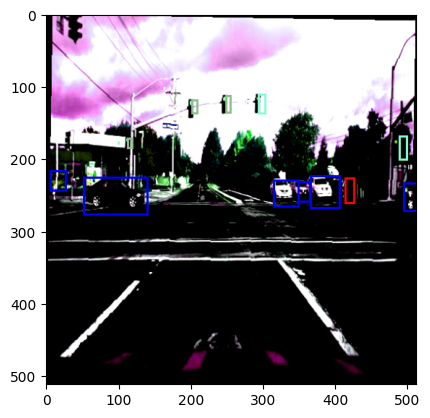

In [106]:
# train_dataset_tr[23]
img, dct = train_dataset_tr[1]
img = transforms.functional.to_pil_image(img)
bboxes = dct['bboxes']
labels = dct['labels']
utils.plot_image(img, bboxes, labels, classes_colors)

In [110]:
cls_out, reg_out = model(train_dataset_tr[:8][0])

TypeError: list indices must be integers or slices, not str

In [113]:
images = []
for i in range(8):
    images.append(train_dataset_tr[i][0].numpy())
images = torch.tensor(images)

In [116]:
cls_outs, reg_outs = model(images)

In [163]:
label = torch.argmax(cls_outs, dim=1)[[0, 2, 4]]
bbox = reg_outs[[0, 2, 4]]

In [137]:
for i in bbox.resize(1, 4):
    a, b, c, d = i
a

tensor(159.2659, grad_fn=<UnbindBackward0>)

In [164]:
bbox

tensor([[159.2659, 236.6120,  25.9514,  83.6213],
        [469.9258, 511.6923, 118.1376,  37.9789],
        [256.1172, 227.6984,  26.6666,  36.5385]], grad_fn=<IndexBackward0>)

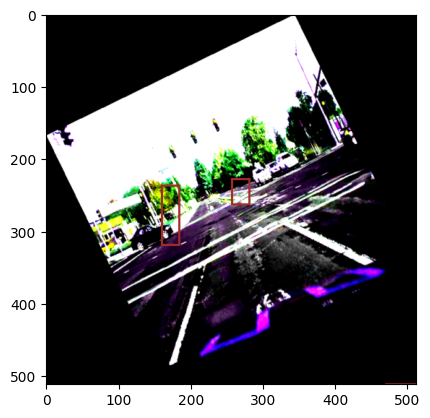

In [165]:
img, dct = train_dataset_tr[1]
img = transforms.functional.to_pil_image(img)
# bboxes = dct['bboxes']
# labels = dct['labels']
utils.plot_image(img, bbox, label, classes_colors)